### Machine Learning Audio Classification MFCC CNN
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
import kapre
from kapre.composed import get_melspectrogram_layer
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import *#Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel


print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.8.0
Num GPUs Available:  1


2022-02-22 14:30:30.280098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 14:30:30.321346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 14:30:30.321586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### DATASET READ IN
In this section we will read in our kaggle 2018 cached and padded

In [3]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)
metadata = pd.concat([train_metadata, test_metadata])

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MFCC train data
X = np.load( os.path.join(data_npy_folder, "X-cache-merged.npy" ))#, allow_pickle=True )
y = np.load( os.path.join(data_npy_folder, "y-cache-merged.npy" ))#, allow_pickle=True )

# # load in pre-processed MFCC train data
# X_test = np.load( os.path.join(data_npy_folder, "X-mfcc-test.npy" ))#, allow_pickle=True )
# y_test = np.load( os.path.join(data_npy_folder, "y-mfcc-test.npy" ))#, allow_pickle=True )


In [4]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

# # output X_train and X_test shape
# print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# # output y_train and y_test shape
# print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Test split: 2214 		 Train split: 8859
X test shape: (2214, 22050) 	 X train shape: (8859, 22050)
y test shape: (2214,) 		 y train shape: (8859,)


### Visualize the label count distribution for train and test data

<BarContainer object of 41 artists>

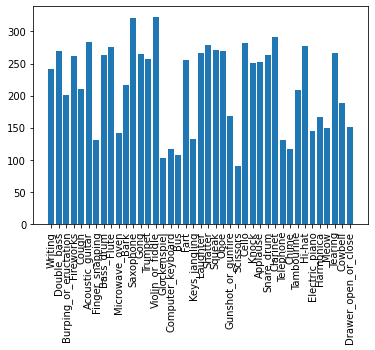

In [5]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

<BarContainer object of 41 artists>

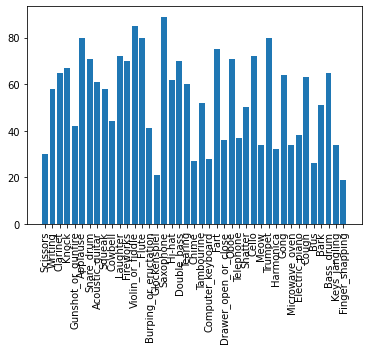

In [6]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

In [7]:
len(labels.keys())

41

### Encode Labels
In this section we will encode to categorical our y data

In [8]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))

In [9]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

n_c = 0
#y_train[0], y_train_encoded[0], num_labels
y_train_encoded[n_c], le.classes_[n_c], num_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 'Acoustic_guitar',
 41)

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [10]:
# n_mfcc = 40
# sampling_rate = 44100
# audio_duration = 4
# audio_length = audio_duration * sampling_rate
# input_shape = (n_mfcc, 517, 1) # 1 + int(np.floor(audio_length/512))
# input_shape
# input_shape = (X_train.shape[0], X_train.shape[2])
# input_shape

# n_mfcc = 40
# sampling_rate = 22050#44100
# audio_duration = 4
# audio_length = audio_duration * sampling_rate
SAMPLE_RATE = 22050
DELTA_TIME = 1
BATCH_SIZE = 32
EPOCHS = 500 # standard we are training for 500 epochs


input_shape = ( SAMPLE_RATE, 1 )#(n_mfcc, 517, 1) # 1 + int(np.floor(audio_length/512))
input_shape

(22050, 1)

In [11]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

X_train.shape, X_test.shape

((8859, 22050, 1), (2214, 22050, 1))

### Construct the model
In this section we will construct the model

### Core ResNet Structures
A ResNet can be called an upgraded version of the VGG architecture, with the difference between them being the skip connections used in ResNets. In the figure below, we can see the architecture of the VGG as well as the 34 layer ResNet.



In [12]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(classes = 10):
    # Step 1 (Setup Input Layer)
    input_shape = (int(SAMPLE_RATE*DELTA_TIME), 1)
    x_input = get_melspectrogram_layer(
        input_shape=input_shape,
        n_mels=128,
        pad_end=True,
        n_fft=512,
        win_length=400,
        hop_length=160,
        sample_rate=SAMPLE_RATE,
        return_decibel=True,
        input_data_format='channels_last',
        output_data_format='channels_last'
    )
    #x = LayerNormalization(axis=2, name='batch_norm')(x_input.output)#(i.output)
    #x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input.output)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input.input, outputs = x, name = "ResNet34")
    return model

In [13]:
if resume is False: # if we are not resuming from a previous model

    model = ResNet34(classes=num_labels)


2022-02-22 14:30:33.169167: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 14:30:33.170977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 14:30:33.172049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 14:30:33.172603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [14]:
# 2. compile the model
if resume is False:
    
    #learning_rate=0.001#0.001
    #beta_1=0.9
    #beta_2=0.999

    # NOTE: values above was overfitting

    learning_rate = 0.001#0.000001
    beta_1 = 0.99
    beta_2 = 0.999
    epsilon=1e-07 
    
    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

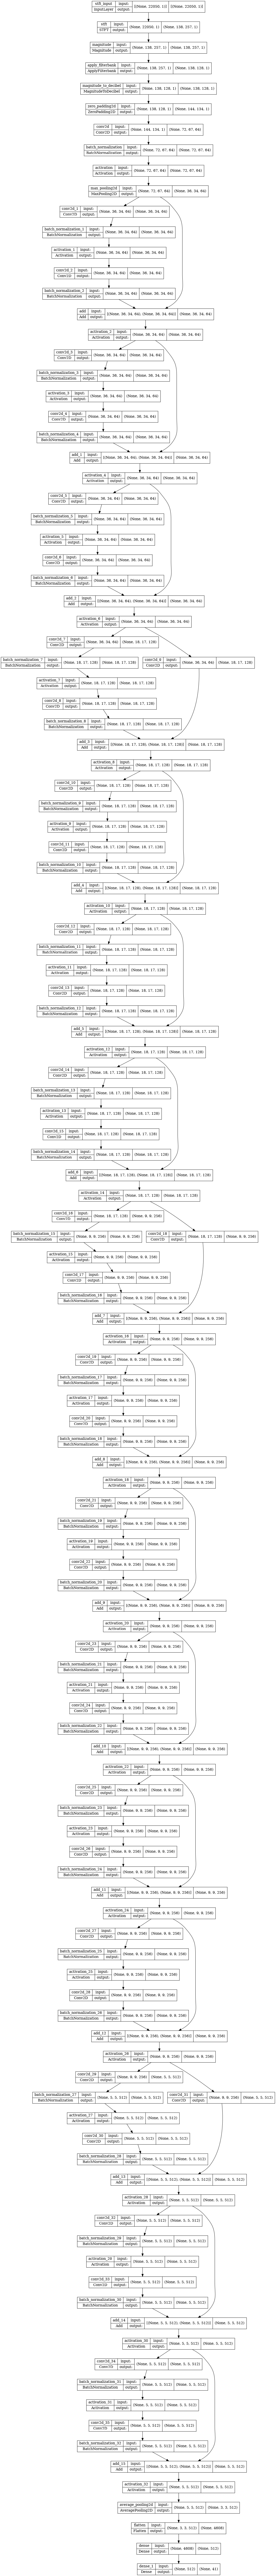

In [15]:
#model.build()
#if resume is False:
plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [17]:
# # set the model path
# model_dir = os.path.join( dataset_root_dir, 'models')

# if resume is False:
#     # this is where we will save the model too
#     model_path = os.path.join(model_dir, f'MFCC_CNN_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_cc_v8.h5')
# else:
#     num_epochs = 500
#     num_batch_size = 64#32 # recommend keeping same as saved model
#     print("Resuming training...")
#     model_path = os.path.join(model_dir, 'MFCC_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v8.h5')
#     # Load best saved model
#     print("Loading best saved model...")
#     model = load_model(model_path)

# model_path

# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'KAPRE-MEL-{model.name.upper()}_lr-{learning_rate}_b1-{beta_1}_b2-{beta_2}_epsilon-{epsilon}_MAX_EPOCH-{EPOCHS}_BATCH-{BATCH_SIZE}.h5')
else:
    num_epochs = 500
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'KAPRE-MEL-RESNET34_lr-1e-06_b1-0.99_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path,custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/KAPRE-MEL-RESNET34_lr-0.001_b1-0.99_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5'

In [24]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

#early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25#/*#15#6#3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    #validation_data=(X_test, y_test_encoded),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.2,#1/12.,
    callbacks=[checkpointer, early_stopping_callback], # early_stopping_callback 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

Epoch 1/500
222/222 [==============================] - ETA: 0s - loss: 2.5152 - accuracy: 0.2939
Epoch 1: val_loss improved from inf to 3.19121, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/KAPRE-MEL-RESNET34_lr-0.001_b1-0.99_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5
222/222 [==============================] - 24s 108ms/step - loss: 2.5152 - accuracy: 0.2939 - val_loss: 3.1912 - val_accuracy: 0.2184
Epoch 2/500
222/222 [==============================] - ETA: 0s - loss: 2.4616 - accuracy: 0.3082
Epoch 2: val_loss did not improve from 3.19121
222/222 [==============================] - 24s 107ms/step - loss: 2.4616 - accuracy: 0.3082 - val_loss: 3.8261 - val_accuracy: 0.1258
Epoch 3/500
222/222 [==============================] - ETA: 0s - loss: 2.4013 - accuracy: 0.3200
Epoch 3: val_loss did not improve from 3.19121
222/222 [==============================] - 24s 107ms/step - loss: 2.4013 - accuracy: 0.3200 - val_loss: 3.5108 - val_accuracy: 0.1913
Epoch 

KeyboardInterrupt: 

In [19]:
# separate the dictionaries loss and accuracy into their own dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']

loss_dict = {'val_loss':val_loss, 'loss':loss}

# separate the dictionaries accuracy and val_accuracy into their own dictionary
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

accuracy_dict = {'val_accuracy':val_accuracy, 'accuracy':accuracy}

Text(0.5, 0, 'epochs')

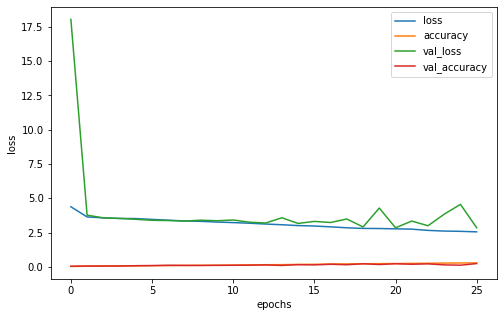

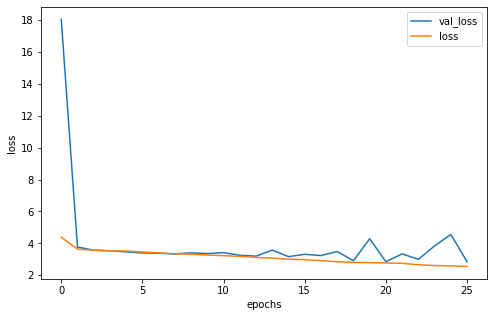

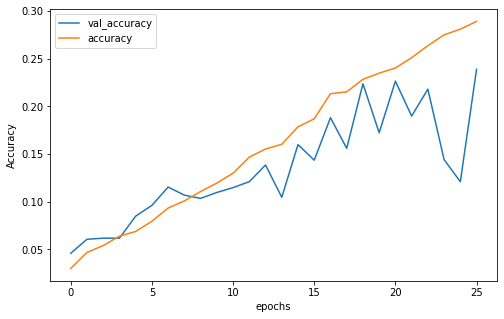

In [20]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

pd.DataFrame(loss_dict).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

pd.DataFrame(accuracy_dict).plot(figsize=(8, 5))
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [21]:

model.metrics_names

['loss', 'accuracy']

In [22]:

# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'KAPRE-MEL-RESNET34_lr-0.001_b1-0.99_b2-0.999_epsilon-1e-07_MAX_EPOCH-500_BATCH-32.h5')


model = load_model(model_path, custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})

In [22]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

70/70 [==============================] - 2s 31ms/step - loss: 2.8578 - accuracy: 0.2313
                    LOSS      ACCURACY
--------------------------------------
Training:         2.5870       28.0731
Test:             2.8578       23.1256
Normal diff          9.48 


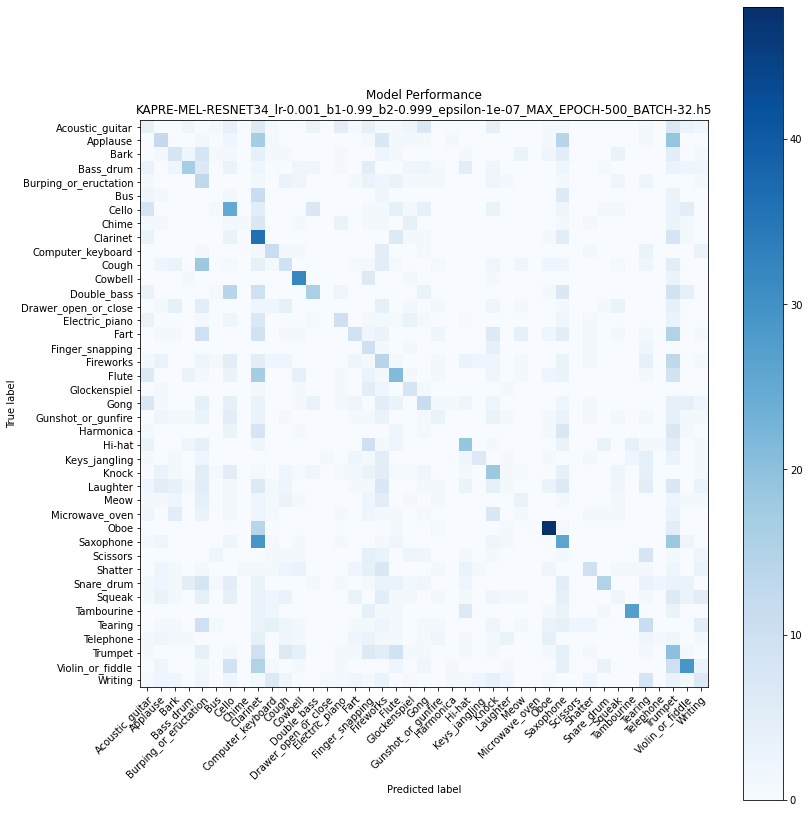

In [23]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=le.classes_.tolist(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [ ]:
importlib.reload(helper)
model, metadata, dfe = helper.load_model_ext(model_path,custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})
model, metadata, dfe

(<keras.engine.functional.Functional at 0x7f88f0144ca0>,
 '["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]',
 'mel')

In [ ]:
import json
lables_properly = le.classes_.tolist()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]'

In [ ]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json, dfe="mel") # mfcc